<a href="https://colab.research.google.com/github/SpaceZeroed/Direct_Pipe/blob/main/New_Direct_pipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Инициализация

In [ ]:

import numpy as np
from scipy.integrate import solve_ivp,solve_bvp
import matplotlib.pyplot as plt
import sympy as sym
from sympy.solvers import ode
import math
sym.init_printing(use_latex=True)
def init():
  global l,m,b,E_soil,q,k,N,Jx,E
  l = 20 #длина трубы
  m = 7800 * l * np.pi * (0.5**2 - 0.49**2) #масса трубы
  E_soil = 4 * 10 ** 7 #модуль Юнга почвы
  q = m * 9.8 / l #погонный вес трубы
  b = 2 * np.sqrt(q * (1 - 0.09) * 0.5 / np.pi / E_soil) # длина дуги
  k0 = 20 * 10 ** 6 #коэффициент жесткости основания для глинистых грунтов пластичных
  k = k0 * 2 * b
  N = 1e5 #сила сжатия трубы
  Jx = np.pi * 0.5**4 / 64 * (1 - 0.49**4 / 0.5**4) #1 / 2 * m / l * (0.5**2 + 0.49**2)**2 #момент инерции
  E = 2.06 * 10**11 #модуль Юнга
def addQdict_maker(X0,Plist,Sigma):
  ans = []
  temp = ('x0','sigma','P')
  for i in range(len(X0)):
    ans.append(dict(zip(temp,(X0[i],Sigma[i],Plist[i]))))
  return ans


## Класс Труба

In [ ]:
class Tube:
  materials_dict = {1 : { 'name': "Сталь",'rho': 7800, 'E': 2.06 * 10**11},
                    2: { 'name': "Каучук",'rho': 920, 'E': 8 * 10**6},
                    3: {'name': "Алюминий",'rho': 2700, 'E': 0.7 * 10**11}}
  def __init__(self,l=20,R=0.5,material_num=1,thickness=0.01,N=1e5,phi=0):
    if l!=0:
      self.__l = abs(l)
    else:
      raise ValueError("L can't be 0")
    if R!=0:
      self.__R = abs(R)
    else:
      raise ValueError("R can't be 0")
    if material_num in self.materials_dict.keys():
      self.__material_num = material_num
    else:
      raise ValueError('Wrong material_num')
    if thickness!=0:
      self.__thickness = abs(thickness)
    else:
      raise ValueError("Thickness can't be 0")
    self.__N = N
    self.__phi = phi
    self.__material_num = material_num
  @property
  def l(self): # длина трубы
    return self.__l
  @l.setter
  def l(self,l):
    if l!=0:
      self.__l = abs(l)
    else:
      raise ValueError("L can't be 0")
  @property
  def R(self): # радиус трубы в сечении
    return self.__R
  @R.setter
  def R(self,R):
    if R!=0:
      self.__R = abs(R)
    else:
      raise ValueError("R can't be 0")
  @property
  def thickness(self):
    return self.__thickness
  @thickness.setter
  def thickness(self,thickness):
    self.__thickness = thickness
  @property
  def material_num(self):
    return self.__material_num
  @material_num.setter
  def material_num(self,material_num):
    if material_num in self.materials_dict.keys():
          self.__material_num = material_num
    else:
          raise ValueError('Wrong material_num')
  @property
  def N(self):
    return self.__N
  @N.setter
  def N(self,N):
    self.__N = N
  @property
  def phi(self):
    return self.__phi
  @phi.setter
  def phi(self,phi):
    self.__phi = phi
  @property
  def E_soil(self):
    return 4 * 10 ** 7 #модуль Юнга почвы
  @property
  def rho(self):
    return self.materials_dict[self.material_num]['rho']
  @property
  def E(self):
    return self.materials_dict[self.material_num]['E']
  @property
  def m(self):
    return self.rho * self.l * np.pi * (self.R**2 - (self.R-self.thickness)**2)
  def q(self): # этот метод будет изменен в трубе
    return self.m * 9.8 / self.l #погонный вес трубы
  def k(self):
    return 40 * 10**6 * 2 * np.sqrt(self.q * (1 - 0.09) * self.R / np.pi / self.E_soil)
  @property
  def Jx(self):
    return np.pi * self.R**4 / 64 * (1 - (self.R-self.thickness)**4 / self.R**4)

## Класс решения трубы

In [ ]:
class TubeSolver(Tube):
  # для добавления кейсов надо править dict_id_dimensions, fun_maker, bc_maker
  dict_id_dimensions = {1:4,2:4}
  bc_id_dimensions = {0:2,1:4,2:4,3:4,4:4,5:4}
  def __init__(self,l=20,R=0.5,material_num=1,thickness=0.01,N=1e5,phi=0,task_id=1,bc_id=1,totalNodes=1000,addQGauss_params=[],addQ_params=[],Q_on=True):
    super().__init__(l=l,R=R,material_num=material_num,thickness=thickness,N=N,phi=phi)
    if task_id in self.dict_id_dimensions.keys():
      self.__task_id = task_id
    else:
      raise ValueError('Wrong task_id')
    if bc_id in self.bc_id_dimensions.keys() and self.bc_id_dimensions[bc_id] == self.dict_id_dimensions[self.task_id]:
      self.__bc_id = bc_id
    else:
      print('bc_id and task_id doesnt match. Set it to default for this task_id')
      self.__bc_id = 1 if self.dict_id_dimensions[self.task_id] == 4 else 0
    if totalNodes!=0:
      self.__totalNodes = abs(totalNodes)
    else:
      raise ValueError("totalNodes can't be 0")
    if type(addQGauss_params) is not list:
      self.__addQGauss_params = [{'x0': 0, 'sigma' : 0, 'P' : 0}]
      print('addQGauss_params didnt set correct .Made it zero')
    else:
      self.__addQGauss_params = addQGauss_params
    if type(addQ_params) is not list:
      self.__addQ_params = [{'x0': 0, 'sigma' : 0, 'P' : 0}]
      print('addQ_params didnt set correct .Made it zero')
    else:
      self.__addQ_params = addQ_params
    if type(Q_on) is not bool:
      self.__Q_on = True
      print('Q_on didnt set correct. Made it True')
    else:
      self.__Q_on = Q_on
  def fun_maker(self):
    dict_fun = {1: lambda x,w : np.vstack((w[1],w[2],w[3], (-self.q(x) - self.k(x) * w[0] - self.N * w[2] ) / ( self.E * self.Jx))),
    2: lambda x,w : np.vstack((w[1],w[2],w[3], (-self.q(x)*np.cos(self.phi)- self.k(x) * w[0] - (self.N+self.q(x)*np.sin(self.phi)) * w[2] ) / ( self.E * self.Jx)))}
    return  dict_fun[self.task_id]
  def bc_maker(self):
    dict_bc = {0 : lambda ya,yb : np.array([ya[0],yb[0]]),
    1: lambda ya,yb : np.array([ya[0], yb[0], ya[2], yb[2]]),
    2: lambda ya,yb : np.array([ya[0], yb[0], ya[1], yb[1]]),
    3: lambda ya,yb : np.array([ya[0],yb[0],ya[1],yb[2]]),
    4: lambda ya,yb : np.array([ya[0],yb[0],ya[2],yb[1]]),
    5: lambda ya,yb : np.array([ya[0],yb[0],ya[3],yb[3]])}
    return dict_bc[self.bc_id]
  @property
  def task_id(self):
    return self.__task_id
  @task_id.setter
  def task_id(self,task_id):
    if task_id in self.dict_id_dimensions.keys():
          self.__task_id = task_id
    else:
          raise ValueError('Wrong task_id')
  @property
  def bc_id(self):
    return self.__bc_id
  @bc_id.setter
  def bc_id(self,id):
    if id in self.bc_id_dimensions.keys() and self.bc_id_dimensions[id] == self.dict_id_dimensions[self.task_id]:
      self.__bc_id = id
    else:
      print('bc_id and task_id doesnt match. Set it to default for this task_id')
      self.__bc_id = 1 if self.dict_id_dimensions[self.task_id] == 4 else 0
  @property
  def totalNodes(self):
    return self.__totalNodes
  @totalNodes.setter
  def totalNodes(self,totalNodes):
    if totalNodes!=0:
      self.__totalNodes = abs(totalNodes)
    else:
      raise ValueError("totalNodes can't be 0")
  @property
  def x(self):
    return np.linspace(0, self.l, self.totalNodes)
  @property
  def y(self):
    return np.zeros((self.dict_id_dimensions[self.task_id], self.x.shape[0]))
  @property
  def solution(self):
    return solve_bvp(self.fun_maker(),self.bc_maker(),self.x,self.y, tol = 1e-10, max_nodes=self.totalNodes)
  def q(self,x):
    temp1,temp2 = 0,0
    dim = len(x)
    #print(dim)
    if len(self.addQGauss_params) > 0:
      addQGauss_array = []
      for i in range(len(self.addQGauss_params)):
        addQGauss_array.append(
            self.addQGauss_params[i]['P'] / math.sqrt(2 * math.pi) / self.addQGauss_params[i]['sigma']* np.exp(- (x - self.addQGauss_params[i]['x0']) ** 2 /
                                                                                                         2 / self.addQGauss_params[i]['sigma'] ** 2) )
      temp1 +=sum(addQGauss_array)
    if len(self.addQ_params) > 0:
      addQ_array = []
      for i in range(len(self.addQ_params)):
        array = []
        for j in range(dim):
          array.append(self.addQ_params[i]['P'] if abs(x[j]-self.addQ_params[i]['x0'])<=self.addQ_params[i]['sigma'] else 0)
        addQ_array.append(array)
      addQ_array = np.array(addQ_array)
      temp2 += sum(addQ_array)
    Q = self.m * 9.8 / self.l if self.Q_on else 0
    return Q + temp1 + temp2 #погонный вес трубы

  def k(self,x):
    return 40 * 10**6 * 2 * np.sqrt(self.q(x) * (1 - 0.09) * self.R / np.pi / self.E_soil)
  @property
  def addQ_params(self):
    return self.__addQ_params
  @addQ_params.setter
  def addQ_params(self,params):
    if type(params) is not list:
      self.__addQ_params = [{'x0': 0, 'sigma' : 0, 'P' : 0}]
      print('addQ_params didnt set.Made it zero')
    else:
      self.__addQ_params = params
  @property
  def addQGauss_params(self):
    return self.__addQGauss_params
  @addQGauss_params.setter
  def addQGauss_params(self,params):
    if type(params) is not list:
      self.__addQGauss_params = [{'x0': 0, 'sigma' : 0, 'P' : 0}]
      print('addQGauss_params didnt set.Made it zero')
    else:
      self.__addQGauss_params = params
  @property
  def Q_on(self):
    return self.__Q_on
  @Q_on.setter
  def Q_on(self,On):
    if type(On) is not bool:
      self.__Q_on = True
      print('Q_on didnt set correct. Made it True')
    else:
      self.__Q_on = On
  def max_deflection(self):
    y_measles_plot = self.solution.sol(self.solution.x)
    ans = round(max(abs(y_measles_plot[0])),6)
    return ans


## Функции для отрисовки

In [ ]:
def set_plot(xlabel='X',ylabel='W',title='Solution',size=(10,6)):
  plt.figure(figsize=size)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
def Plotting(solution,legend='Undefined'):
  y_measles_plot = solution.sol(solution.x)
  print(f'Максимальный изгиб:{max(abs(y_measles_plot[0]))}')
  plt.plot(solution.x, y_measles_plot[0], label=legend)
  plt.legend(loc='lower right')

## Класс для стержня в канале

In [ ]:
class CanalRod():
  def __init__(self,l=20,n=1):
    if l!=0:
      self.__l = abs(l)
    else:
      raise ValueError("L can't be 0")
    if n>0:
      self.__n = n
    else:
      raise ValueError("n can't be 0 or negative")
  @property
  def l(self): # длина трубы
    return self.__l
  @l.setter
  def l(self,l):
    if l!=0:
      self.__l = abs(l)
    else:
      raise ValueError("L can't be 0")
  @property
  def n(self):
    return self.__n
  @n.setter
  def n(self,n):
    if n>0:
      self.__n = n
    else:
      raise ValueError("n can't be 0 or negative")
  def RodCount(self):
    if n<16:
      return 1
    else:
      i=0
      while n>=16*9**i:
        i+=1
      return 3**i
class Rod():
   def __init__(self,l=20,n=1):
      self.__l = l
      self.__n = n
   @property
   def l(self):
      return self.__l
   @property
   def n(self):
      return self.__n
   @property
   def E(self):
    return 2.06 * 10**11



# Решение горизонтальной задачи

Максимальный изгиб:0.013480923862872236


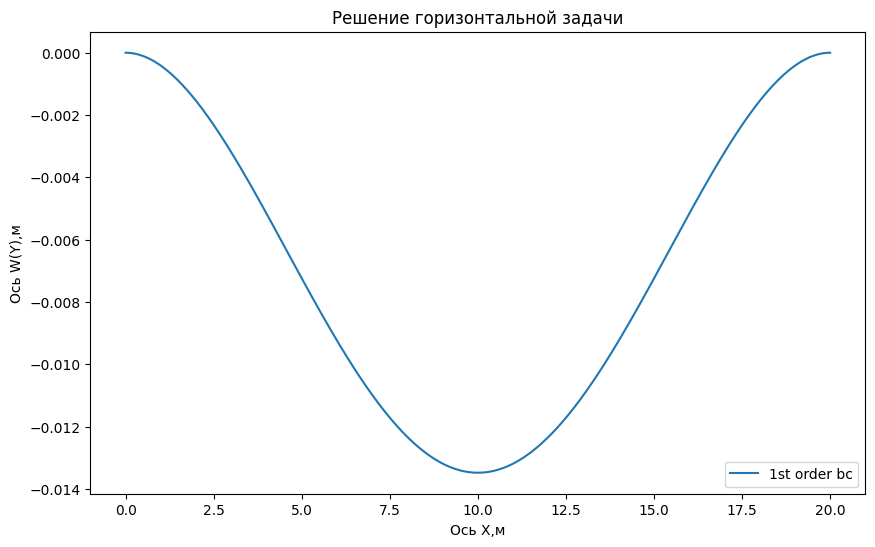

In [ ]:
T1 = TubeSolver(l=20,N=5e6)
set_plot(xlabel='Ось X,м',ylabel='Ось W(Y),м',title='Решение горизонтальной задачи')
#Plotting(T1.solution,'2nd order bc')
T1.bc_id = 2
Plotting(T1.solution,'1st order bc')
T1.bc_id = 3
#Plotting(T1.solution,'1st on left, 2nd on right')
T1.bc_id = 4
#Plotting(T1.solution,'2nd on left, 1st on right')
T1.bc_id = 5
#Plotting(T1.solution,'3rd order bc')
plt.show()


## Изгиб в зависимости от параметров

### Продольная сила N

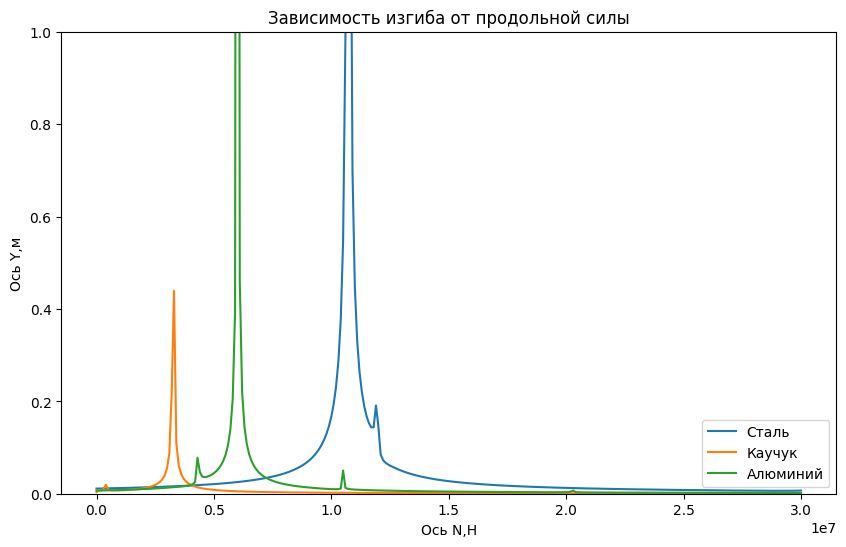

In [ ]:
T1 = TubeSolver()
deflection_value_forN = [dict() for _ in range(len(T1.materials_dict))]
for i in range(0,30001,100):
  T1.N = 1e3*i
  for j in range(len(T1.materials_dict)):
    T1.material_num = j + 1
    deflection_value_forN[j][T1.N] = T1.max_deflection()
set_plot(xlabel='Ось N,Н',ylabel='Ось Y,м',title='Зависимость изгиба от продольной силы')
for i in range(len(T1.materials_dict)):
  plt.plot(deflection_value_forN[i].keys(), deflection_value_forN[i].values(), label=T1.materials_dict[i+1]['name'])
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()

### Радиус трубы

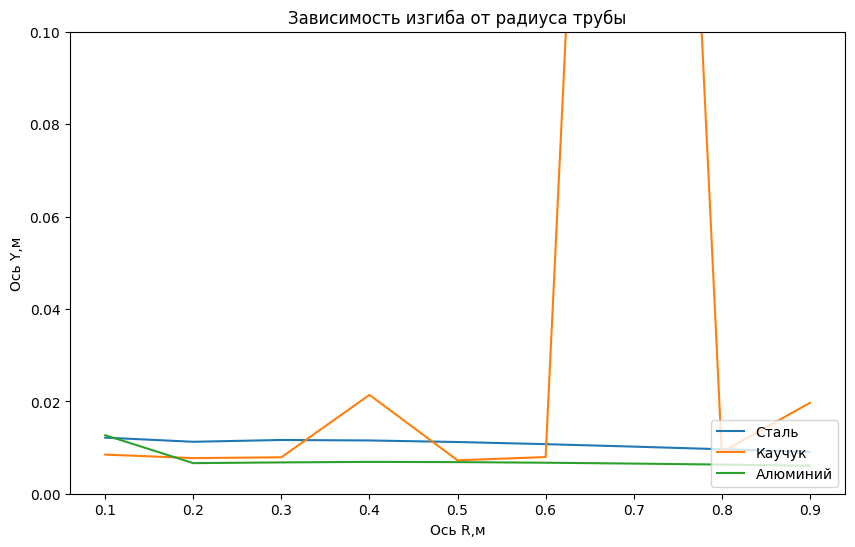

In [ ]:
T1 = TubeSolver()
deflection_value_forR = [dict() for _ in range(len(T1.materials_dict))]
for i in range(1,10):
  T1.R = 0.1*i
  for j in range(len(T1.materials_dict)):
    T1.material_num = j + 1
    deflection_value_forR[j][T1.R] = T1.max_deflection()
set_plot(xlabel='Ось R,м',ylabel='Ось Y,м',title='Зависимость изгиба от радиуса трубы')
for i in range(len(T1.materials_dict)):
  plt.plot(deflection_value_forR[i].keys(), deflection_value_forR[i].values(), label=T1.materials_dict[i+1]['name'])
plt.legend(loc='lower right')
plt.ylim(0,0.1)
plt.show()

# Решение наклонной задачи

Максимальный изгиб:0.00969388689700188
Максимальный изгиб:0.0068519296142472074


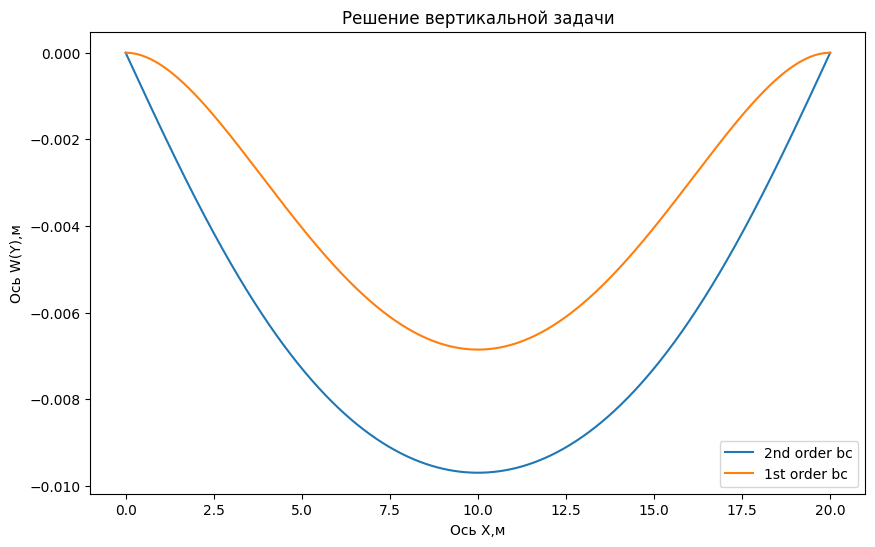

In [ ]:
T2 = TubeSolver(task_id=2,phi=np.pi/6)
set_plot(xlabel='Ось X,м',ylabel='Ось W(Y),м',title='Решение вертикальной задачи')
Plotting(T2.solution,'2nd order bc')
T2.bc_id= 2
Plotting(T2.solution,'1st order bc')
plt.show()

## Изгиб в зависимости от параметров

### продольная сила N

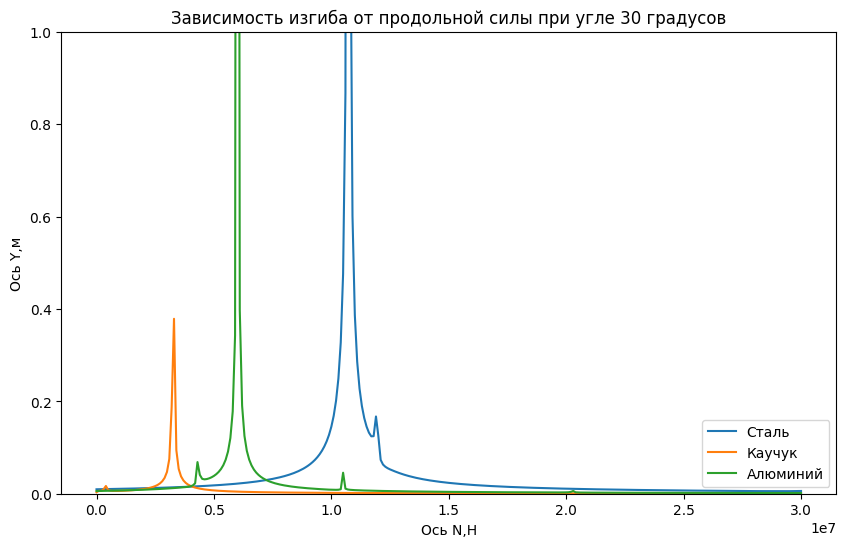

In [ ]:
T1 = TubeSolver(task_id = 2,phi = np.pi/6)
deflection_value_forN = [dict() for _ in range(len(T1.materials_dict))]
for i in range(0,30001,100):
  T1.N = 1e3*i
  for j in range(len(T1.materials_dict)):
    T1.material_num = j + 1
    deflection_value_forN[j][T1.N] = T1.max_deflection()
set_plot(xlabel='Ось N,Н',ylabel='Ось Y,м',title='Зависимость изгиба от продольной силы при угле 30 градусов')
for i in range(len(T1.materials_dict)):
  plt.plot(deflection_value_forN[i].keys(), deflection_value_forN[i].values(), label=T1.materials_dict[i+1]['name'])
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()

### угол phi

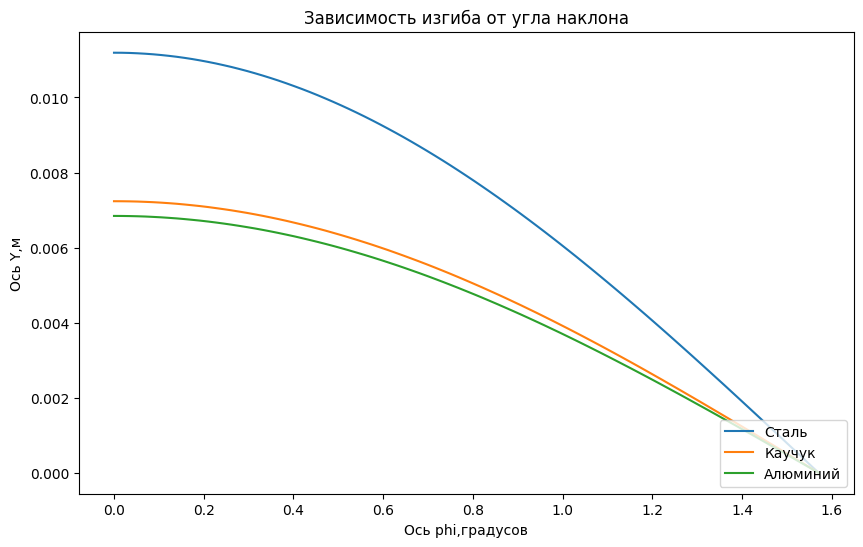

In [ ]:
T1 = TubeSolver(task_id = 2,phi = 0)
deflection_value_forPhi = [dict() for _ in range(len(T1.materials_dict))]
for i in range(0,91):
  T1.phi = np.pi/180*i
  for j in range(len(T1.materials_dict)):
    T1.material_num = j + 1
    deflection_value_forPhi[j][T1.phi] = T1.max_deflection()
set_plot(xlabel='Ось phi,радиан',ylabel='Ось Y,м',title='Зависимость изгиба от угла наклона')
for i in range(len(T1.materials_dict)):
  plt.plot(deflection_value_forPhi[i].keys(), deflection_value_forPhi[i].values(), label=T1.materials_dict[i+1]['name'])
plt.legend(loc='lower right')
plt.show()

# Невесомый стержень и гауссова сила

Максимальный изгиб:0.001123435547673999
Максимальный изгиб:0.0052191106526327585
Максимальный изгиб:0.019370975330625567
Максимальный изгиб:0.0679446933510579
Максимальный изгиб:0.23285262231629283
Максимальный изгиб:0.7620484207164279
Максимальный изгиб:2.410785545213293


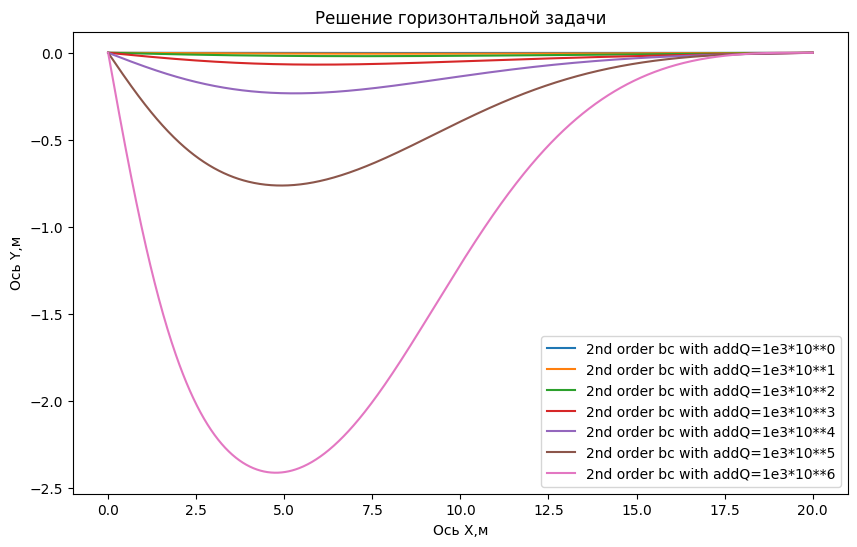

In [ ]:
addQ = addQdict_maker(X0=[5],Sigma=[3],Plist=[1e3])
T1 = TubeSolver(l=20,addQ_params=[],addQGauss_params=addQ,Q_on = False)
set_plot(xlabel='Ось X,м',ylabel='Ось Y,м',title='Решение горизонтальной задачи')
for i in range(7):
  T1.addQGauss_params = addQdict_maker(X0=[5],Sigma=[3],Plist=[1e3*10**i])
  Plotting(T1.solution,f'2nd order bc with addQ=1e3*10**{i}')
plt.show()

Максимальный изгиб:0.010538934852425125
Максимальный изгиб:0.009026405934375328
Максимальный изгиб:0.00797087136266669
Максимальный изгиб:0.00711855526076887
Максимальный изгиб:0.0064199236711615475
Максимальный изгиб:0.005859217898511001
Максимальный изгиб:0.005418209579803326
Максимальный изгиб:0.005075602124056736
Максимальный изгиб:0.004810732400850443
Максимальный изгиб:0.004605734152776254


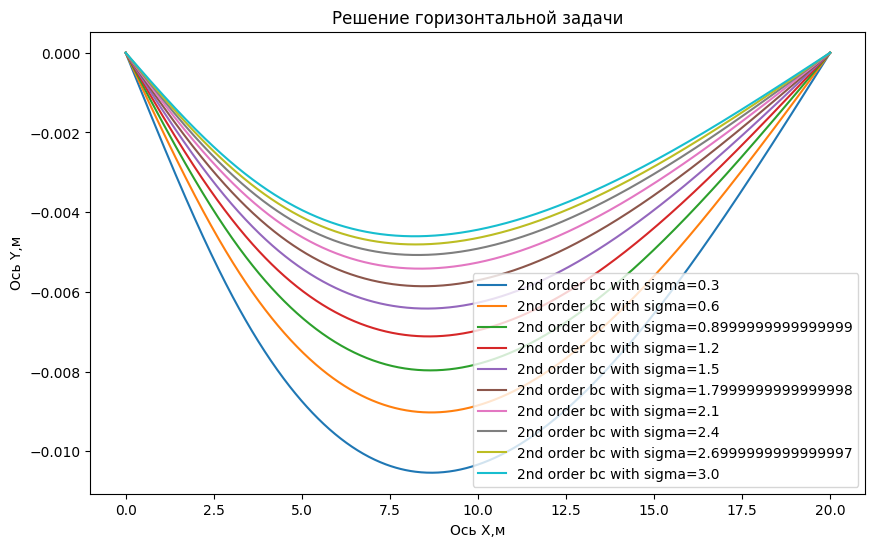

In [ ]:
addQ = addQdict_maker(X0=[5],Sigma=[3],Plist=[1e4])
T1 = TubeSolver(l=20,addQ_params=[],addQGauss_params=[],Q_on = False)
set_plot(xlabel='Ось X,м',ylabel='Ось Y,м',title='Решение горизонтальной задачи')
for i in range(10):
  T1.addQGauss_params = addQdict_maker(X0=[3],Sigma=[0.3*(i+1)],Plist=[1e4])
  Plotting(T1.solution,f'2nd order bc with sigma={0.3*(i+1)}')
plt.show()

# Различные решения

Максимальный изгиб:0.012035240110459802
Максимальный изгиб:0.019666005742886215
Максимальный изгиб:0.062106482118068976
Максимальный изгиб:0.21257611461211257
Максимальный изгиб:0.689323723933623
Максимальный изгиб:2.1605750460069473
Максимальный изгиб:6.737529097247674


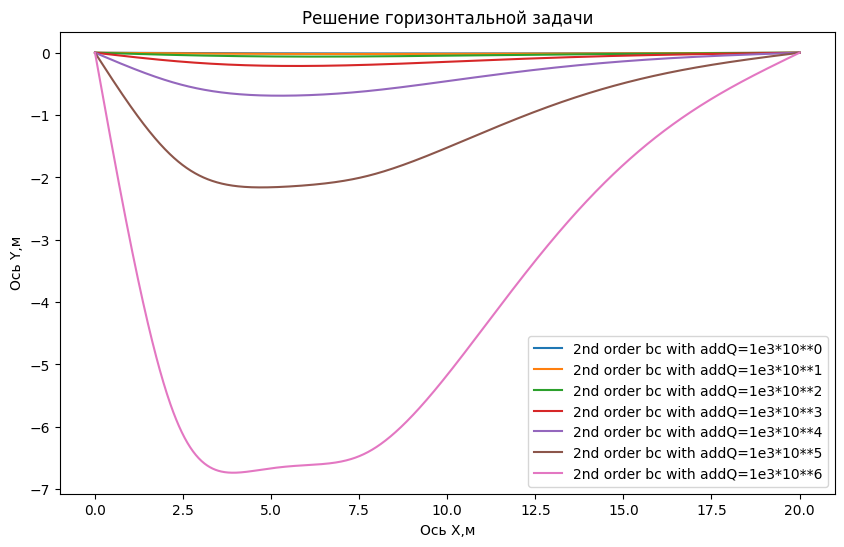

In [ ]:
addQ = addQdict_maker(X0=[5],Sigma=[3],Plist=[1e3])
T1 = TubeSolver(l=20,addQ_params=addQ,addQGauss_params=[])
set_plot(xlabel='Ось X,м',ylabel='Ось Y,м',title='Решение горизонтальной задачи')
for i in range(7):
  T1.addQ_params = addQdict_maker(X0=[5],Sigma=[3],Plist=[1e3*10**i])
  Plotting(T1.solution,f'2nd order bc with addQ=1e3*10**{i}')
plt.show()

Максимальный изгиб:0.21257611461211257
Максимальный изгиб:0.24236912212672057
Максимальный изгиб:0.240641060531013


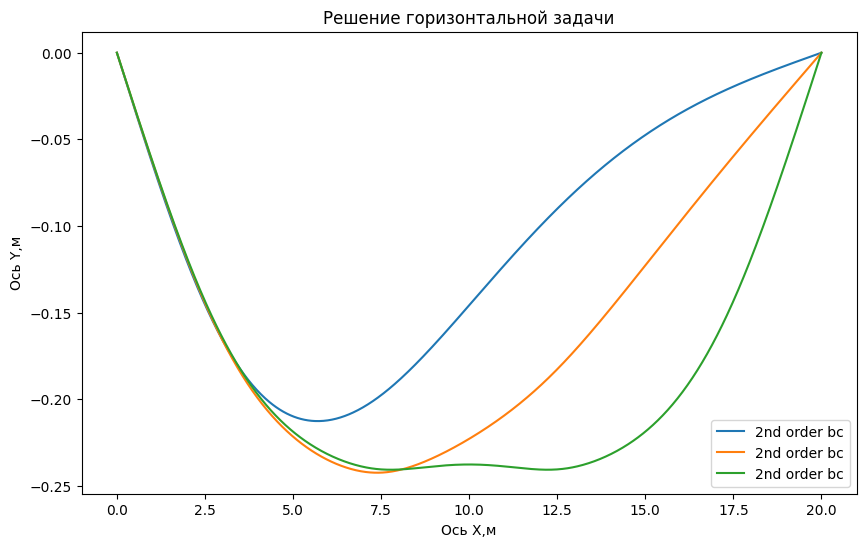

In [ ]:
addQ = addQdict_maker(X0=[5],Sigma=[3],Plist=[1e6])
T1 = TubeSolver(l=20,addQ_params=addQ,addQGauss_params=[])
set_plot(xlabel='Ось X,м',ylabel='Ось Y,м',title='Решение горизонтальной задачи')
Plotting(T1.solution,'2nd order bc')
T1.bc_id = 2
#Plotting(T1.solution,'1st order bc')
T1.bc_id = 1
addQ = addQdict_maker(X0=[5,10],Sigma=[3,3],Plist=[1e6,1e6])
T1.addQ_params = addQ
Plotting(T1.solution,'2nd order bc')
T1.bc_id = 2
#Plotting(T1.solution,'1st order bc')
T1.bc_id = 1
addQ = addQdict_maker(X0=[5,10,15],Sigma=[3,3,3],Plist=[1e6,1e6,1e6])
T1.addQ_params = addQ
Plotting(T1.solution,'2nd order bc')
T1.bc_id = 2
#Plotting(T1.solution,'1st order bc')
plt.show()

Максимальный изгиб:0.21257611461211257
Максимальный изгиб:0.20885173709457386


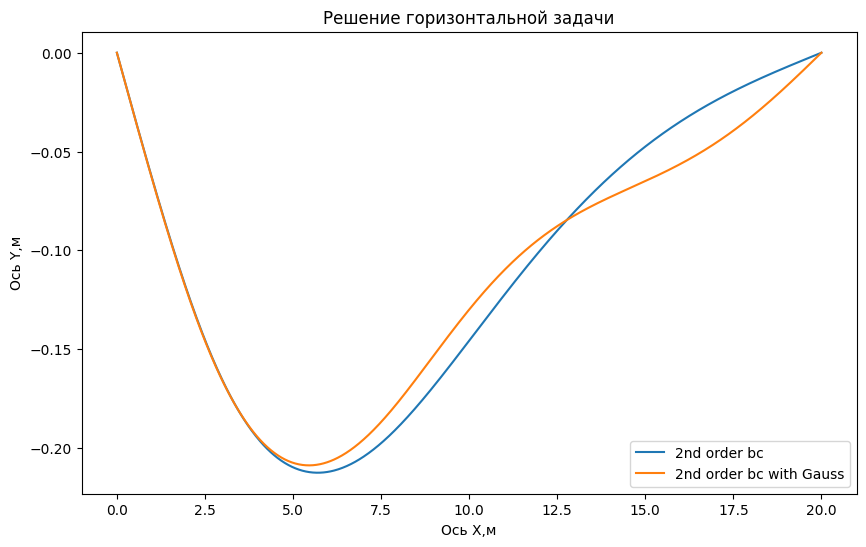

In [ ]:
addQ = addQdict_maker(X0=[5],Sigma=[3],Plist=[1e6])
addQGauss = addQdict_maker(X0=[15],Sigma=[3],Plist=[1e6])
T1 = TubeSolver(l=20,addQ_params=addQ,addQGauss_params=[])
set_plot(xlabel='Ось X,м',ylabel='Ось Y,м',title='Решение горизонтальной задачи')
Plotting(T1.solution,'2nd order bc')
T1.addQGauss_params = addQGauss
Plotting(T1.solution,'2nd order bc with Gauss')
plt.show()

# Old

dw/dz = a -> dw/dz = w[1]


q = 2377.4190901600023 k = 234716.5030414353
Max deflection  is:0.01098505489500774


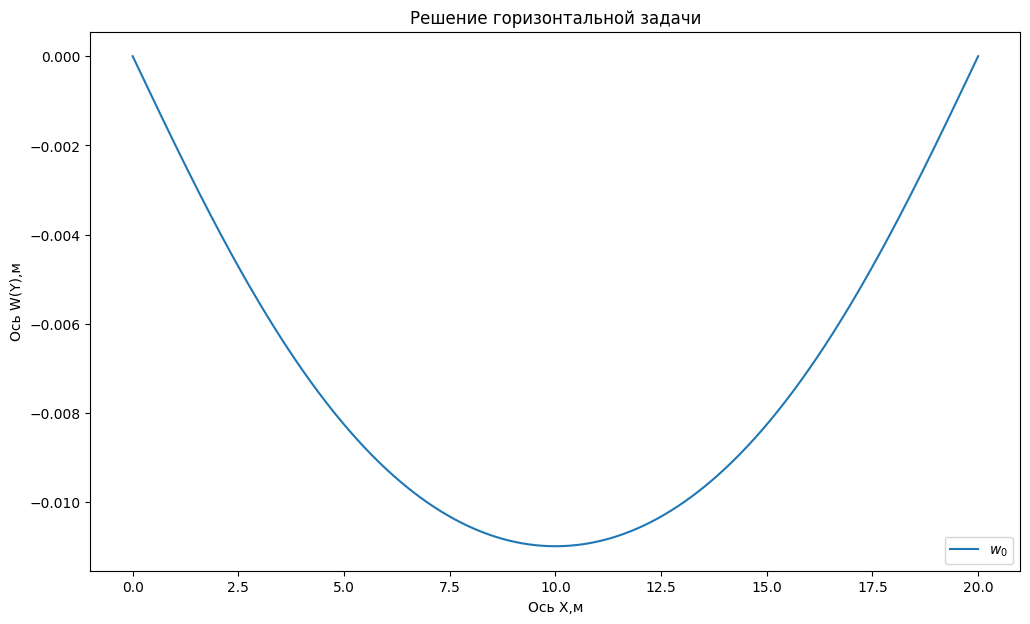

In [ ]:
# Решаем краевую задачу через SciPy
init()

print("q =", q, "k =", k)
#print(q/( E * Jx) , N/( E * Jx), ( E * Jx))
# Правые части системы
def fun(x,w):
  return np.vstack((w[1],w[2],w[3], (-q - k * w[0] + N * w[2] ) / ( E * Jx)))
# Краевые условия
def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[2], yb[2]])
totalNodes = 1000
x = np.linspace(0, l, totalNodes)
y_a = np.zeros((4, x.shape[0]))
solbc = solve_bvp(fun,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
#print(solbc)
x_measles_plot = np.linspace(0, l, totalNodes)
y_measles_plot = solbc.sol(x_measles_plot)
yy = solbc.y[0]
print(f'Max deflection  is:{max(abs(yy))}')
set_plot(xlabel='Ось X,м',ylabel='Ось W(Y),м',title='Решение горизонтальной задачи')
plt.plot(x_measles_plot, y_measles_plot[0], label='$w_0$')
plt.legend(loc='lower right')
#plt.plot(x_measles_plot, y_measles_plot[1], label='$y_1$')
#plt.plot(x_measles_plot, y_measles_plot[2], label='$y_2$')
#plt.plot(x_measles_plot, y_measles_plot[3], label='$y_3$')
plt.show()

**Увеличение усилия N с шагом 1e5 от 1e5 до 1e6**

Max deflection  is:0.010140239463684619
Max deflection  is:0.00934203247008755
Max deflection  is:0.008660382700758428
Max deflection  is:0.008071493988084318
Max deflection  is:0.007557634897138577
Max deflection  is:0.007105322499029377
Max deflection  is:0.006704121904448935
Max deflection  is:0.00634583104500081
Max deflection  is:0.006023913797635598
Max deflection  is:0.005733097459652076


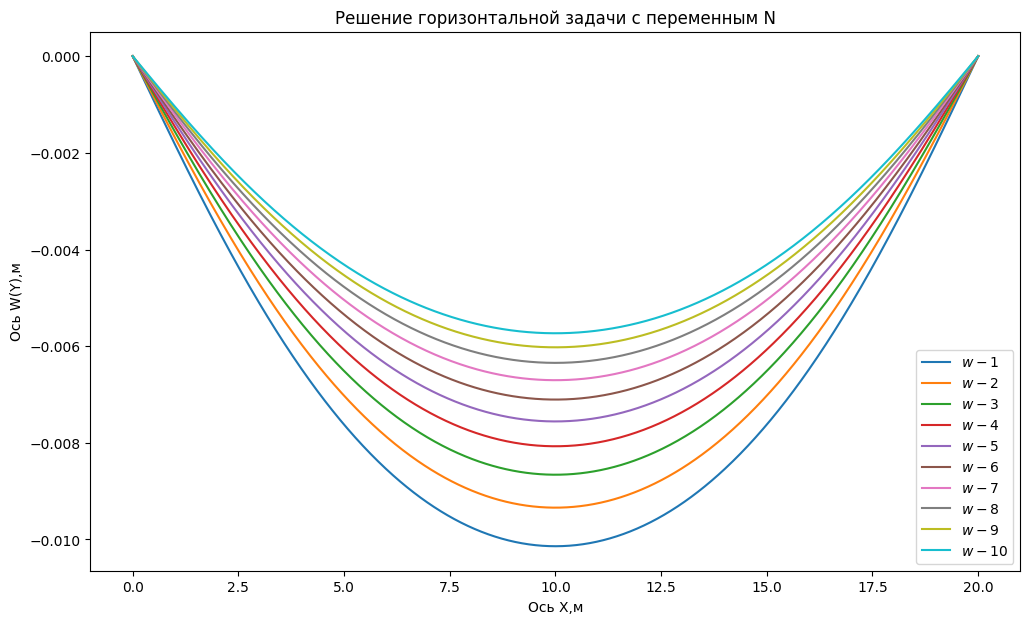

In [ ]:
# Цикл
# Правые части системы
def fun(x,w):
  return np.vstack((w[1],w[2],w[3], (-q - k * w[0] + N * w[2] ) / ( E * Jx)))
# Краевые условия
def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[2], yb[2]])
totalNodes = 1000
n = 10
x_measles_plot = np.linspace(0, l, totalNodes)
set_plot(xlabel='Ось X,м',ylabel='Ось W(Y),м',title='Решение горизонтальной задачи c переменным N')
for i in range(1,n+1):
  init()
  global N
  N = 1e6*i #сила сжатия трубы
  x = np.linspace(0, l, totalNodes)
  y_a = np.zeros((4, x.shape[0]))
  solbci = solve_bvp(fun,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
  y_measles_plot = solbci.sol(x_measles_plot)
  plt.plot(x_measles_plot, y_measles_plot[0], label=f'$w-{i}$')
  plt.legend(loc='lower right')
  #plt.plot(y_measles_plot[0], y_measles_plot[1], label='$y_0/ y_1$')
  yy = solbci.y[0]
  print(f'Max deflection  is:{max(abs(yy))}')
plt.show()

In [ ]:
def init2(Phi):
  init()
  global Ftr, Tn, Ttau, phi, k2
  phi = Phi
  Tn = q * np.cos(phi)
  Ttau = q * np.sin(phi)
  b = 2 * np.sqrt(Tn * (1 - 0.09) * 0.5 / np.pi / E_soil) # длина дуги
  k0 = 20 * 10 ** 6 #коэффициент жесткости основания для глинистых грунтов пластичных
  k2 = k0 * 2 * b

Ttau = 1188.709545080001 k2 = 218428.31824181243
4.845613041126937e-05 0.0020381821030977013 49063329.44834343


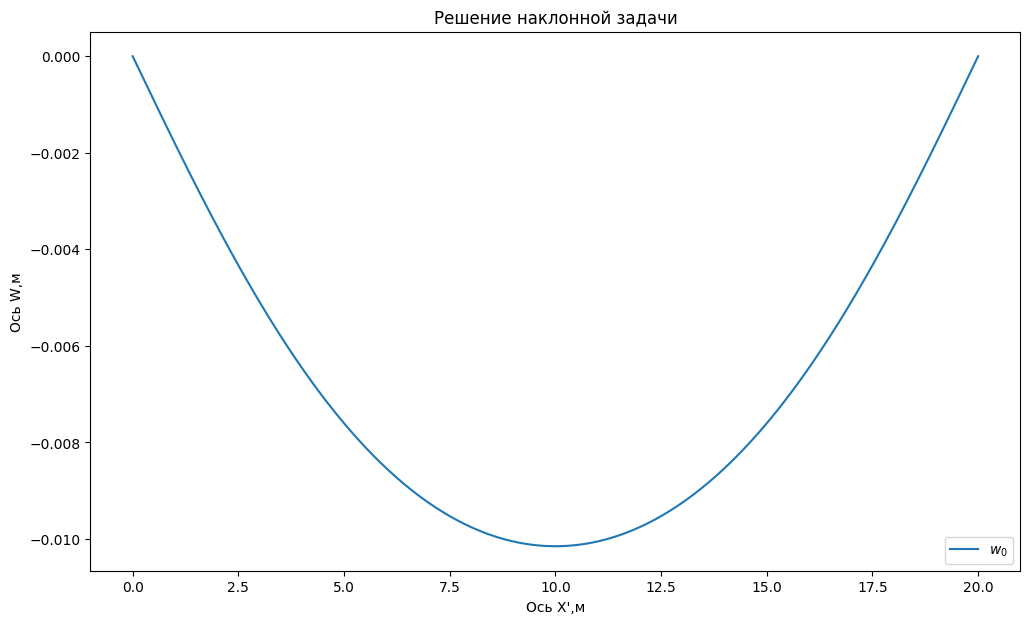

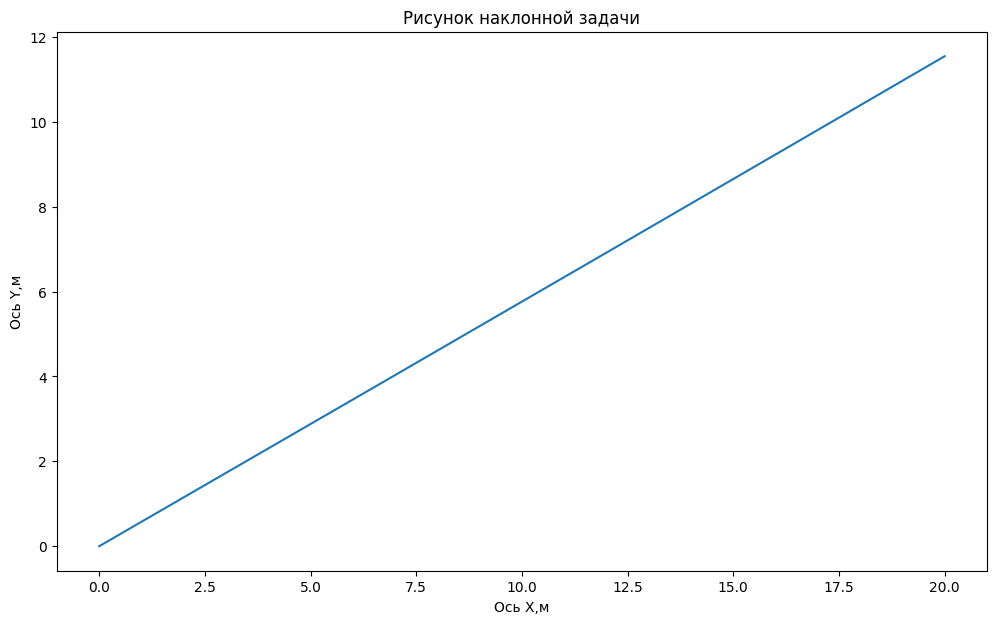


Max deflection  is:0.010148964478154247


In [ ]:
# Решаем краевую задачу через SciPy
init2(np.pi/6)
print("Ttau =", Ttau, "k2 =", k2)
print(q/( E * Jx) , N/( E * Jx), ( E * Jx))
# Правые части системы
def fun2(x,w):
  return np.vstack((w[1],w[2],w[3], (-Tn - k2 * w[0] + N * w[2] ) / ( E * Jx)))
# Краевые условия
def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[2], yb[2]])
totalNodes = 1000
x = np.linspace(0, l, totalNodes)
y_a = np.zeros((4, x.shape[0]))
solbc = solve_bvp(fun2,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
#print(solbc)
x_measles_plot = np.linspace(0, l, totalNodes)
y_measles_plot = solbc.sol(x_measles_plot)
set_plot(xlabel="Ось X',м",ylabel='Ось W,м',title='Решение наклонной задачи')
plt.plot(x_measles_plot, y_measles_plot[0], label='$w_0$')
#plt.plot(x_measles_plot, y_measles_plot[1], label='$y_1$')
#plt.plot(x_measles_plot, y_measles_plot[2], label='$y_2$')
#plt.plot(x_measles_plot, y_measles_plot[3], label='$y_3$')
plt.legend(loc='lower right')
plt.show()
set_plot(xlabel="Ось X,м",ylabel='Ось Y,м',title='Рисунок наклонной задачи')
y_fig = np.zeros_like(x_measles_plot)
for i in range(totalNodes):
    y_fig[i] = y_measles_plot[0][i] +x_measles_plot[i]*np.tan(phi)
#print(y_fig)
plt.plot(x_measles_plot, y_fig, label='$y_0$')
plt.show()
yy = solbc.y[0]
print()
print(f'Max deflection  is:{max(abs(yy))}')

Max deflection  is:0.010778107378466932
Max deflection  is:0.010148964478154247
Max deflection  is:0.00906688006579462
Max deflection  is:0.007452334418411204
Max deflection  is:0.005067965007734276
Max deflection  is:5.7081691468968174e-18


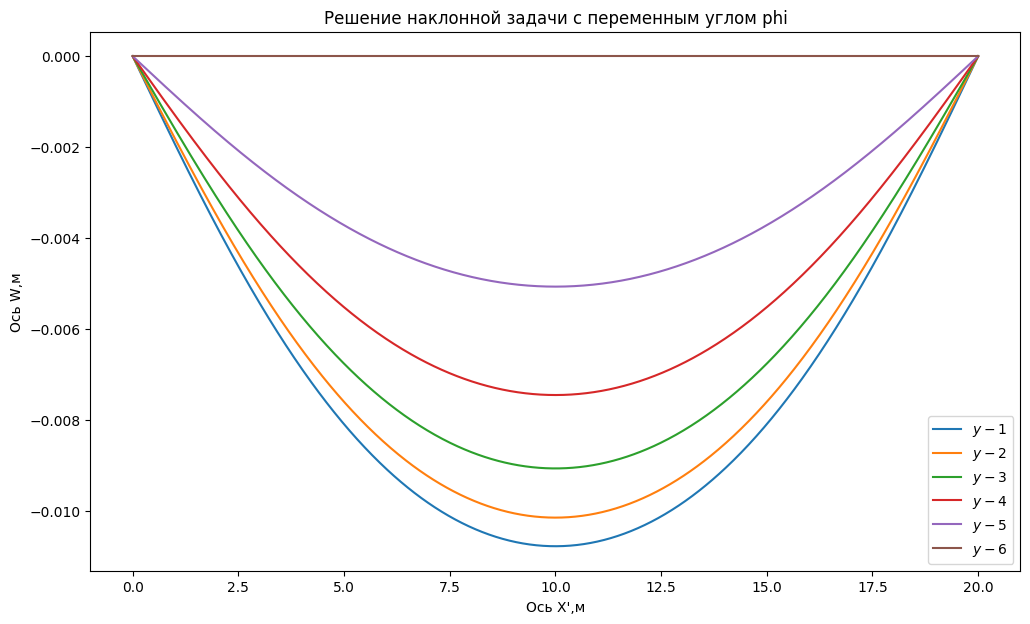

1.5707963267948966


In [ ]:
init2(0)
# Цикл
def fun2(x,w):
  return np.vstack((w[1],w[2],w[3], (-Tn - k2 * w[0] + N * w[2] ) / ( E * Jx)))
def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[2], yb[2]])
totalNodes = 1000
n = 6
x_measles_plot = np.linspace(0, l, totalNodes)
set_plot(xlabel="Ось X',м",ylabel='Ось W,м',title='Решение наклонной задачи с переменным углом phi')
for i in range(1,n+1):
  Phi = np.pi * i / 12
  init2(Phi)
  x = np.linspace(0, l, totalNodes)
  y_a = np.zeros((4, x.shape[0]))
  solbci = solve_bvp(fun2,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
  y_measles_plot = solbci.sol(x_measles_plot)
  plt.plot(x_measles_plot, y_measles_plot[0], label=f'$y-{i}$')
  #plt.plot(y_measles_plot[0], y_measles_plot[1], label='$y_0/ y_1$')
  plt.legend(loc='lower right')
  yy = solbci.y[0]
  print(f'Max deflection  is:{max(abs(yy))}')
plt.show()
print(phi)

#Уравнение движения


In [ ]:
def init3():
  init2(np.pi/6)
  global mu, N0, Nend, ktr, Fp
  print("m =", m)
  mu = 3 #пластическая вязкость
  N0 = 5000
  Nend = 0
  ktr = 0.39 #коэффициент трения
  Fp = N0 - Nend + Ttau * l - ktr * Tn * l


m = 4851.875694204086
q = 2377.4190901600023 k = 234716.5030414353
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.004e-03 ...  3.996e+00  4.000e+00]
        y: [[ 0.000e+00  2.101e-05 ...  2.091e+01  2.095e+01]
            [ 0.000e+00  1.049e-02 ...  1.046e+01  1.047e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 38
     njev: 0
      nlu: 0
Max deflection  is:20.94736849015054


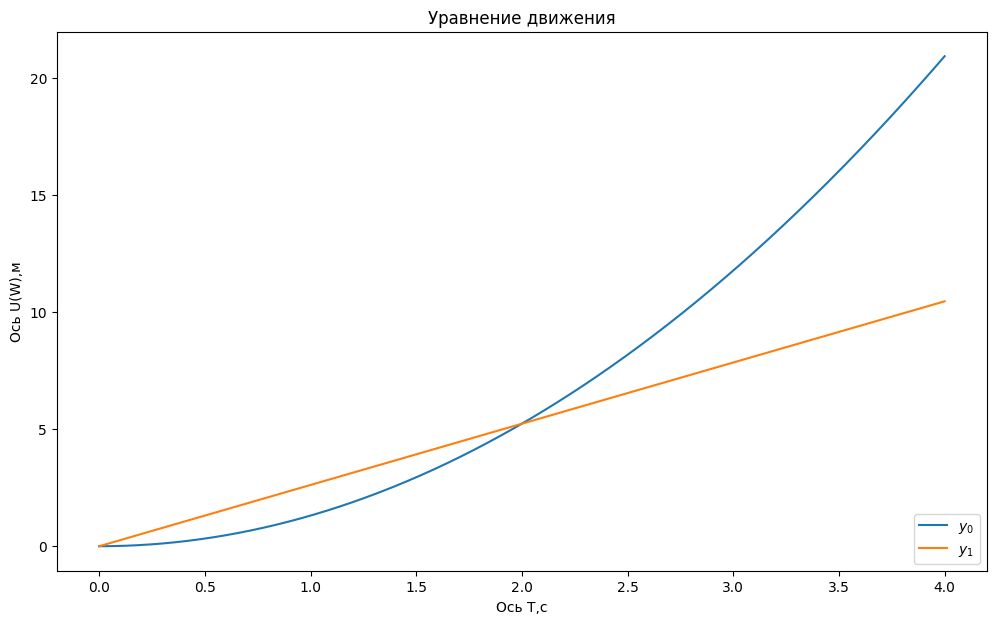

In [ ]:
init3()
print("q =", q, "k =", k)
#print(q/( E * Jx) , N/( E * Jx), ( E * Jx))
# Правые части системы
#def fun3(x,w):
  #return np.vstack((w[1], (N0 - Nend - mu * w[1] + Ttau * l - ktr * Tn * l) / m))
def rhs(t,u):
  r = np.zeros(2)
  r[0] = u[1]
  r[1] = (N0 - Nend - mu * u[1] + Ttau * l - ktr * Tn * l) / m
  return r
# Краевые условия
def bc(ua, ub):
  return np.array([ua[0], ua[1]])
totalNodes = 1000
T = 4
t = np.linspace(0, T, totalNodes)
u_a = np.zeros((2, t.shape[0]))
#solbc = solve_bvp(fun3,bc,t,u_a, tol = 1e-10, max_nodes=totalNodes)
solbc = solve_ivp(rhs,(0,T),[0,0],rtol=1e-8,t_eval=t)
print(solbc)
t_measles_plot = np.linspace(0, T, totalNodes)
#u_measles_plot = solbc.sol(t_measles_plot)
uu = solbc.y[0]
uu1 = solbc.y[1]
print(f'Max deflection  is:{max(abs(uu))}')
set_plot(xlabel="Ось T,c",ylabel='Ось U(W),м',title='Уравнение движения')
plt.plot(t_measles_plot, uu, label='$y_0$')
plt.plot(t_measles_plot, uu1, label='$y_1$')
#plt.plot(x_measles_plot, y_measles_plot[1], label='$y_1$')
#plt.plot(x_measles_plot, y_measles_plot[2], label='$y_2$')
#plt.plot(x_measles_plot, y_measles_plot[3], label='$y_3$')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
#totalNodes = 1000
#rho = 700
#h = 2
#b2 = 2
#l2 = 5
#Ssec = b2 * h
#mu = 3
#ktr = 0.39
#C = rho ** 2 * 9.8 * b2 * Ssec / mu ** 2 * (np.sin(np.pi / 6) - ktr * np.cos(np.pi / 6))
#t_measles_plot = np.linspace(0, 20, totalNodes)
#print(len(t_measles_plot))
#u_measles_plot = C * l2 *np.exp(-mu * t_measles_plot / rho / Ssec) - C * l2 + C * l2 * mu * t_measles_plot / rho / Ssec
#print(len(u_measles_plot))
#plt.plot(t_measles_plot, u_measles_plot)
#plt.legend(loc='lower right')
#plt.show()

# Вариант решения наклонной задачи с движением

m = 4851.875694204086
q = 2377.4190901600023 k = 234716.5030414353
7714.729346938955
Max deflection  is:0.008914612866519582


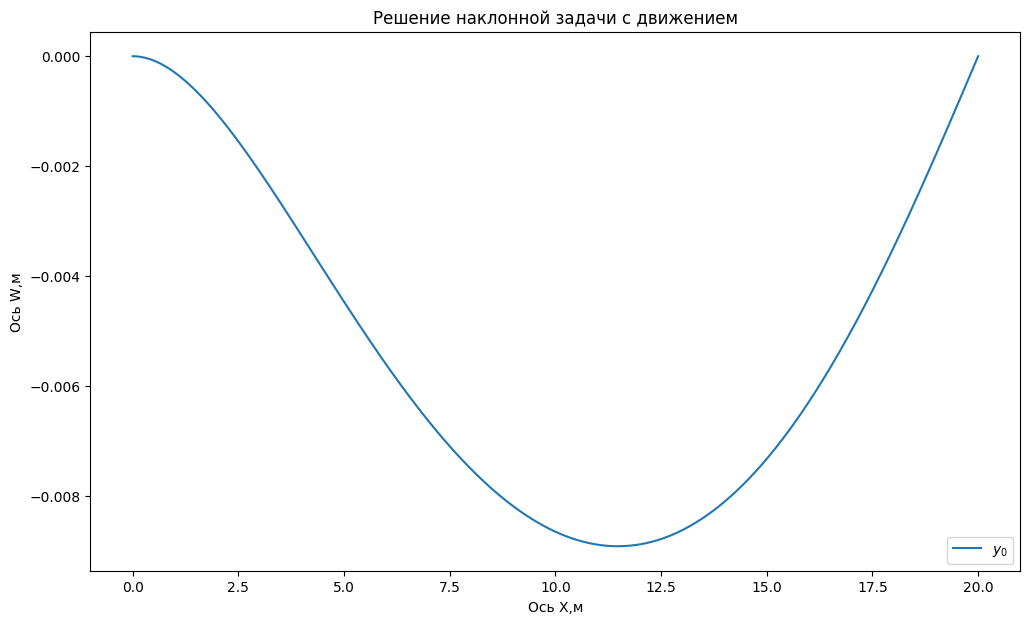

In [ ]:
init3()
print("q =", q, "k =", k)
#print(q/( E * Jx) , N/( E * Jx), ( E * Jx))
# Правые части системы
def fun(x,w):
  t = 1
  return np.vstack((w[1],w[2],w[3], (-Tn - k2 * w[0] + (N0 - Fp * np.exp(-mu * t / m)) * w[2] ) / ( E * Jx)))
print(Ttau * l - ktr * Tn * l)
# Краевые условия
def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[1], yb[2]])
totalNodes = 1000
x = np.linspace(0, l, totalNodes)
y_a = np.zeros((4, x.shape[0]))
solbc = solve_bvp(fun,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
#print(solbc)
x_measles_plot = np.linspace(0, l, totalNodes)
y_measles_plot = solbc.sol(x_measles_plot)
yy = solbc.y[0]
print(f'Max deflection  is:{max(abs(yy))}')
set_plot(xlabel="Ось X,м",ylabel='Ось W,м',title='Решение наклонной задачи с движением')
plt.plot(x_measles_plot, y_measles_plot[0], label='$y_0$')
#plt.plot(x_measles_plot, y_measles_plot[1], label='$y_1$')
#plt.plot(x_measles_plot, y_measles_plot[2], label='$y_2$')
#plt.plot(x_measles_plot, y_measles_plot[3], label='$y_3$')
plt.legend(loc='lower right')
plt.show()

m = 4851.875694204086
Max deflection  is:0.009432847316151674
Max deflection  is:0.008819133323928672
Max deflection  is:0.007770558339846402
Max deflection  is:0.006226202934400322
Max deflection  is:0.004009213262682035
Max deflection  is:2.4726799164467854e-18


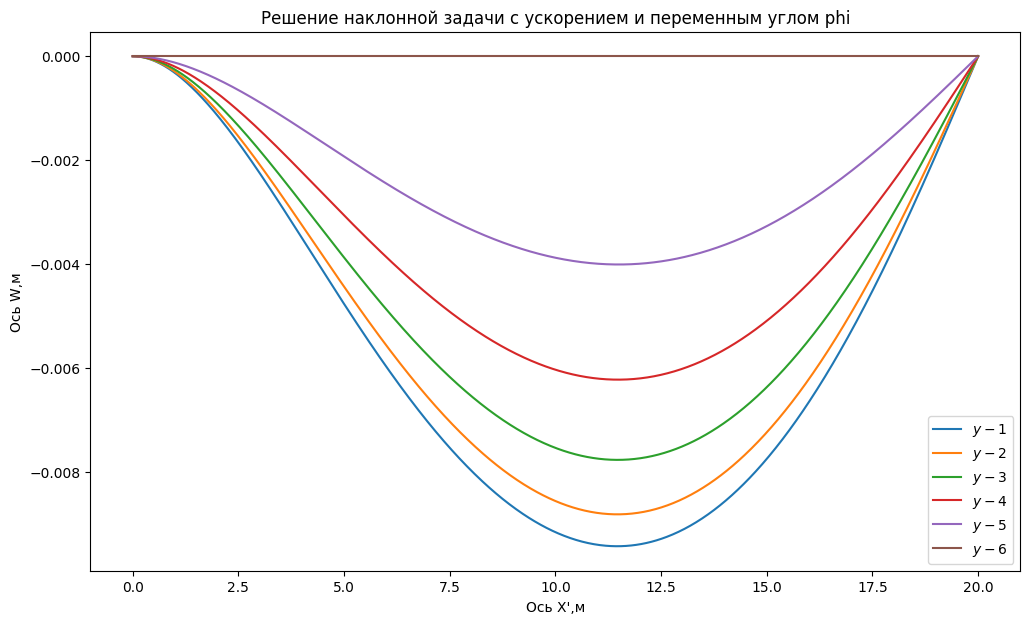

1.5707963267948966


In [ ]:
init3()
# Цикл
def fun2(x,w):
  return np.vstack((w[1],w[2],w[3], (-Tn - k2 * w[0] + N * w[2] ) / ( E * Jx)))
def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[1], yb[2]])
totalNodes = 1000
n = 6
x_measles_plot = np.linspace(0, l, totalNodes)
set_plot(xlabel="Ось X',м",ylabel='Ось W,м',title='Решение наклонной задачи с ускорением и переменным углом phi')
for i in range(1,n+1):
  Phi = np.pi * i / 12
  init2(Phi)
  x = np.linspace(0, l, totalNodes)
  y_a = np.zeros((4, x.shape[0]))
  solbci = solve_bvp(fun2,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
  y_measles_plot = solbci.sol(x_measles_plot)
  plt.plot(x_measles_plot, y_measles_plot[0], label=f'$y-{i}$')
  #plt.plot(y_measles_plot[0], y_measles_plot[1], label='$y_0/ y_1$')
  plt.legend(loc='lower right')
  yy = solbci.y[0]
  print(f'Max deflection  is:{max(abs(yy))}')
plt.show()
print(phi)

m = 4851.875694204086
Max deflection  is:0.008919034656695283
Max deflection  is:0.008918964751349184
Max deflection  is:0.008918895278053448
Max deflection  is:0.008918826234123933
Max deflection  is:0.008918757616896724
Max deflection  is:0.008918689423728234
Max deflection  is:0.00891862165199527
Max deflection  is:0.008918554299094899
Max deflection  is:0.008918487362404458
Max deflection  is:0.008918420839361675


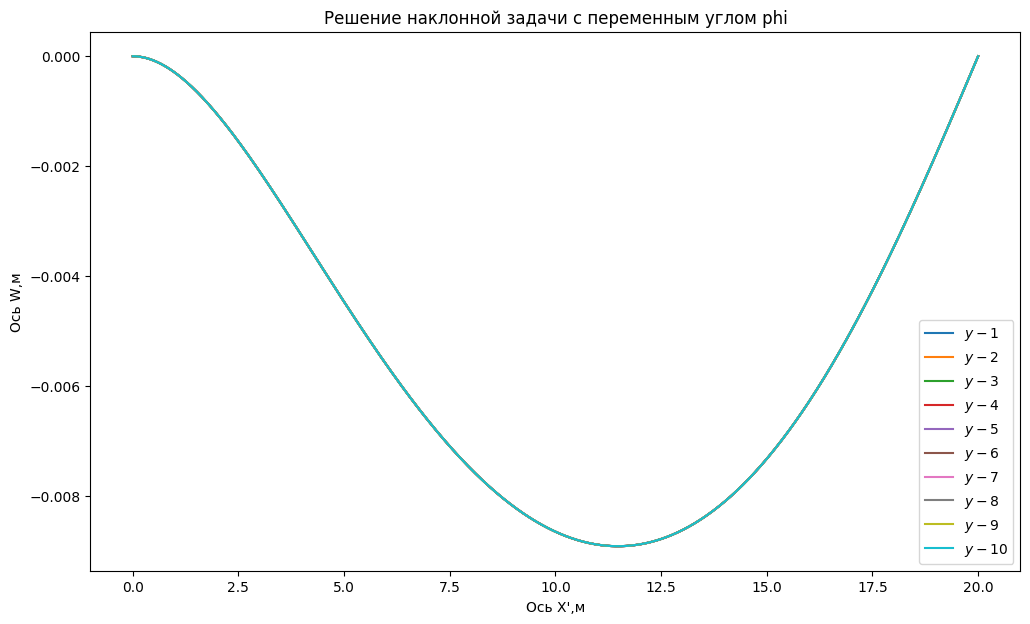

0.5235987755982988


In [ ]:
init3()
# Цикл
t = 0
def fun3(x,w):
  return np.vstack((w[1],w[2],w[3], (-Tn - k2 * w[0] + (Nend - Fp * np.exp(-mu * t / m)) * w[2] ) / ( E * Jx)))
def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[1], yb[2]])
totalNodes = 1000
n = 10
x_measles_plot = np.linspace(0, l, totalNodes)
plt.figure(figsize=(12,7))
plt.xlabel("Ось X',м")
plt.ylabel('Ось W,м')
plt.title('Решение наклонной задачи с переменным углом phi')
for i in range(1,n+1):
  t = i * 10
  x = np.linspace(0, l, totalNodes)
  y_a = np.zeros((4, x.shape[0]))
  solbci = solve_bvp(fun3,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
  y_measles_plot = solbci.sol(x_measles_plot)
  plt.plot(x_measles_plot, y_measles_plot[0], label=f'$y-{i}$')
  #plt.plot(y_measles_plot[0], y_measles_plot[1], label='$y_0/ y_1$')
  plt.legend(loc='lower right')
  yy = solbci.y[0]
  print(f'Max deflection  is:{max(abs(yy))}')
plt.show()
print(phi)

# Вертикальная задача(Эйлера)

In [ ]:
def Euler_init():
  global l,m,b,E_soil,q,k,N,Jx,E
  l = 20 #длина трубы
  m = 7800 * l * np.pi * (0.5**2 - 0.49**2) #масса трубы
  #E_soil = 4 * 10 ** 7 #модуль Юнга почвы
  q = m * 9.8 / l #погонный вес трубы
  #b = 2 * np.sqrt(q * (1 - 0.09) * 0.5 / np.pi / E_soil) # длина дуги
  #k0 = 20 * 10 ** 6 #коэффициент жесткости основания для глинистых грунтов пластичных
  #k = k0 * 2 * b
  N = 1e8 #сила сжатия трубы
  Jx = np.pi * 0.5**4 / 64 * (1 - 0.49**4 / 0.5**4) #1 / 2 * m / l * (0.5**2 + 0.49**2)**2 #момент инерции
  E = 2.06 * 10**11 #модуль Юнга

100000000.0
0.00023817150217642443
49063329.44834343
1.4276491526624115
-2.038182103097702
       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 0.000e+00  2.002e-02 ...  1.998e+01  2.000e+01]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x7b1774f377e0>
             p: [ 1.571e-01]
             y: [[ 0.000e+00  3.145e-04 ...  3.145e-04  0.000e+00]
                 [ 1.571e-02  1.571e-02 ... -1.571e-02 -1.571e-02]]
            yp: [[ 1.571e-02  1.571e-02 ... -1.571e-02 -1.571e-02]
                 [-0.000e+00 -7.759e-06 ... -7.759e-06 -0.000e+00]]
 rms_residuals: [ 4.414e-13  4.415e-13 ...  4.415e-13  4.413e-13]
         niter: 1
Max deflection  is:0.09999987641324921
1210589.1306386688


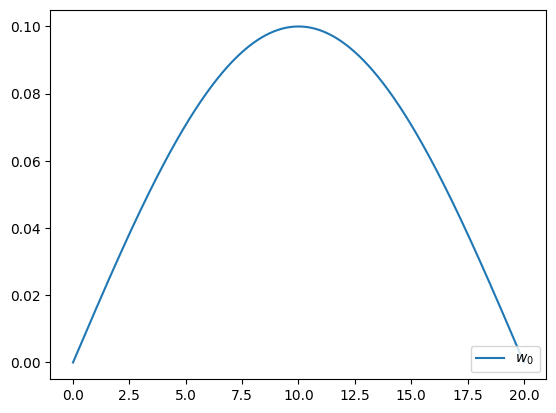

In [ ]:
# Решаем краевую задачу через SciPy
Euler_init()
# Правые части системы
print(N)
print(Jx)
print(E*Jx)
acc = np.sqrt(N/(E*Jx))
print(acc)
print(-acc**2)
A=0.1
def Euler_fun(x,w,p):
  k = p[0]
  return np.vstack((w[1],-k**2*w[0]))
# Краевые условия
def bc_E0(ya, yb,p): # шарниры
  k = p[0]
  return np.array([ya[0], yb[0],ya[1]-A*k])
n = 1
totalNodes = 1000
x = np.linspace(0, l, totalNodes)
w = np.zeros((2, x.shape[0]))
#w [0,-2] = 1
#w [0,1] = 1
w [0,totalNodes//2-1] = 1
solbc = solve_bvp(Euler_fun,bc_E0,x,w, tol = 1e-10, max_nodes=totalNodes,p=[1*np.pi*n/(l)])
#solbc = solve_bvp(Euler_fun,bc_E0,x,w, tol = 1e-10, max_nodes=totalNodes,p=[6.2])
print(solbc)
x_measles_plot = np.linspace(0, l, totalNodes)
w_measles_plot = solbc.sol(x_measles_plot)
yy = solbc.y[0]
print(f'Max deflection  is:{max(abs(yy))}')
P_crit = np.pi**2*E*Jx/(1*l**2)
print(P_crit)
#set_plot(xlabel='Ось X,м',ylabel='Ось W(Y),м',title='Решение вертикальной задачи')
plt.plot(x_measles_plot, w_measles_plot[0], label='$w_0$')
plt.legend(loc='lower right')

#x = np.linspace(0, l, totalNodes)
#w = np.zeros((2, x.shape[0]))
#solbc = solve_bvp(Euler_fun,bc_E1,x,w, tol = 1e-10, max_nodes=totalNodes,p=[acc])
#print(solbc)
#x_measles_plot = np.linspace(0, l, totalNodes)
#w_measles_plot = solbc.sol(x_measles_plot)
#yy = solbc.y[0]
#print(f'Max deflection  is:{max(abs(yy))}')
#plt.plot(x_measles_plot, w_measles_plot[0], label='$w_1$')
#plt.legend(loc='lower right')
plt.show()

# Вертикальная задача с распределенной нагрузкой


In [ ]:
def Euler_init2():
  global l,m,b,E_soil,q,k,N,Jx,E
  r = 0.5
  l = 2000 #длина трубы
  m = 11340 * l * np.pi * (r**2 - (r-0.01)**2) #масса трубы
  #E_soil = 4 * 10 ** 7 #модуль Юнга почвы
  q = m * 9.8 / l #погонный вес трубы
  #b = 2 * np.sqrt(q * (1 - 0.09) * 0.5 / np.pi / E_soil) # длина дуги
  #k0 = 20 * 10 ** 6 #коэффициент жесткости основания для глинистых грунтов пластичных
  #k = k0 * 2 * b
  N = 1e10 #сила сжатия трубы
  Jx = np.pi * 0.5**4 / 64 * (1 - (r-0.01)**4 / r**4) #1 / 2 * m / l * (0.5**2 + 0.49**2)**2 #момент инерции
  E = 0.9* 10**9 #модуль Юнга для rezina

10000000000.0
214354.351958782
3456.401600309542
215.99010091466036
-46651.72369312517
[0.0, 0.8070425046552373, 1.6140850093104746, 2.4211275139657116, 3.228170018620949, 4.035212523276186, 4.842255027931423, 5.64929753258666, 6.456340037241898, 7.263382541897135, 8.070425046552373, 8.87746755120761, 9.684510055862846, 10.491552560518084, 11.29859506517332, 12.10563756982856, 12.912680074483797, 13.719722579139034, 14.52676508379427, 15.333807588449506, 16.140850093104746, 16.947892597759985, 17.75493510241522, 18.561977607070457, 19.369020111725693, 20.176062616380932, 20.983105121036168, 21.790147625691407, 22.59719013034664, 23.40423263500188, 24.21127513965712, 25.018317644312354, 25.825360148967594, 26.632402653622826, 27.43944515827807, 28.2464876629333, 29.05353016758854, 29.860572672243777, 30.667615176899012, 31.474657681554255]
       message: The maximum number of mesh nodes is exceeded.
       success: False
        status: 1
             x: [ 0.000e+00  2.002e+00 ...  1.9

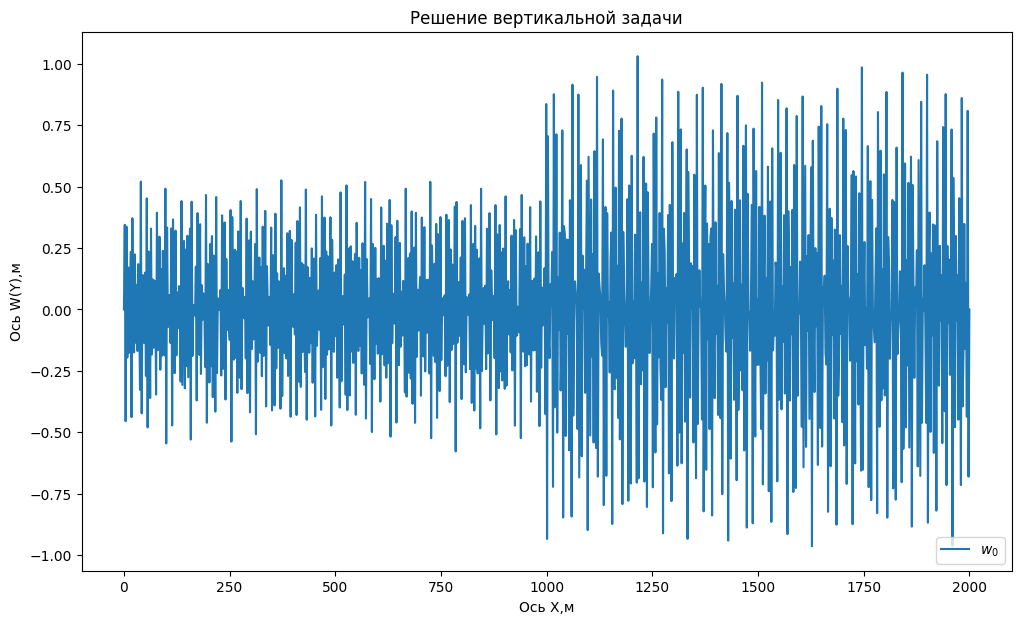

In [ ]:
# Решаем краевую задачу через SciPy
Euler_init2()
# Правые части системы
print(N)
print(E*Jx)
print(q)
acc = np.sqrt(N/(E*Jx))
print(acc)
print(-acc**2)
def Euler_fun2(x,w,p):
  k = p[0]
  return np.vstack((w[1],-k**2*w[0]))
# Краевые условия
def bc_E1(ya, yb,p): # шарниры
  k = p[0]
  return np.array([ya[0], yb[0],ya[1]-k])
n = 1
totalNodes = 1000
x = np.linspace(0, l, totalNodes)
w = np.zeros((2, x.shape[0]))
#w [0,-2] = 1
#w [0,1] = 1
w [0,totalNodes//2-1] = 1
test = [(y*q)/(E*Jx) for y in x]
print(test[::25])
solbc = solve_bvp(Euler_fun2,bc_E1,x,w, tol = 1e-10, max_nodes=totalNodes,p=[1])
print(solbc)
x_measles_plot = np.linspace(0, l, totalNodes)
w_measles_plot = solbc.sol(x_measles_plot)
yy = solbc.y[0]
print(f'Max deflection  is:{max(abs(yy))}')
P_crit = np.pi**2*E*Jx/(1*l**2)
print(P_crit)
set_plot(xlabel='Ось X,м',ylabel='Ось W(Y),м',title='Решение вертикальной задачи')
plt.plot(x_measles_plot, w_measles_plot[0], label='$w_0$')
plt.legend(loc='lower right')

#x = np.linspace(0, l, totalNodes)
#w = np.zeros((2, x.shape[0]))
#solbc = solve_bvp(Euler_fun,bc_E1,x,w, tol = 1e-10, max_nodes=totalNodes,p=[acc])
#print(solbc)
#x_measles_plot = np.linspace(0, l, totalNodes)
#w_measles_plot = solbc.sol(x_measles_plot)
#yy = solbc.y[0]
#print(f'Max deflection  is:{max(abs(yy))}')
#plt.plot(x_measles_plot, w_measles_plot[0], label='$w_1$')
#plt.legend(loc='lower right')
plt.show()

# Задание n-ное

In [ ]:
def DLCtask_init():
  global rho, S, mu, E, l1, z
  rho = 1200
  mu = 3
  E = 5 * 10 ** 6
  S = 1000
  l1 = 20
  z = 20

       message: The maximum number of mesh nodes is exceeded.
       success: False
        status: 1
             x: [ 0.000e+00  4.004e-03 ...  3.996e+00  4.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x7963fd92f970>
             p: None
             y: [[ 0.000e+00  7.856e-05 ...  3.053e+00  3.072e+00]
                 [ 0.000e+00  3.924e-02 ...  4.583e+00  4.571e+00]]
            yp: [[ 0.000e+00  3.924e-02 ...  4.583e+00  4.571e+00]
                 [ 9.800e+00  9.800e+00 ... -2.922e+00 -2.999e+00]]
 rms_residuals: [ 1.479e-08  1.424e-08 ...  7.613e-09  7.451e-09]
         niter: 1
Max deflection  is:4.703984120569423


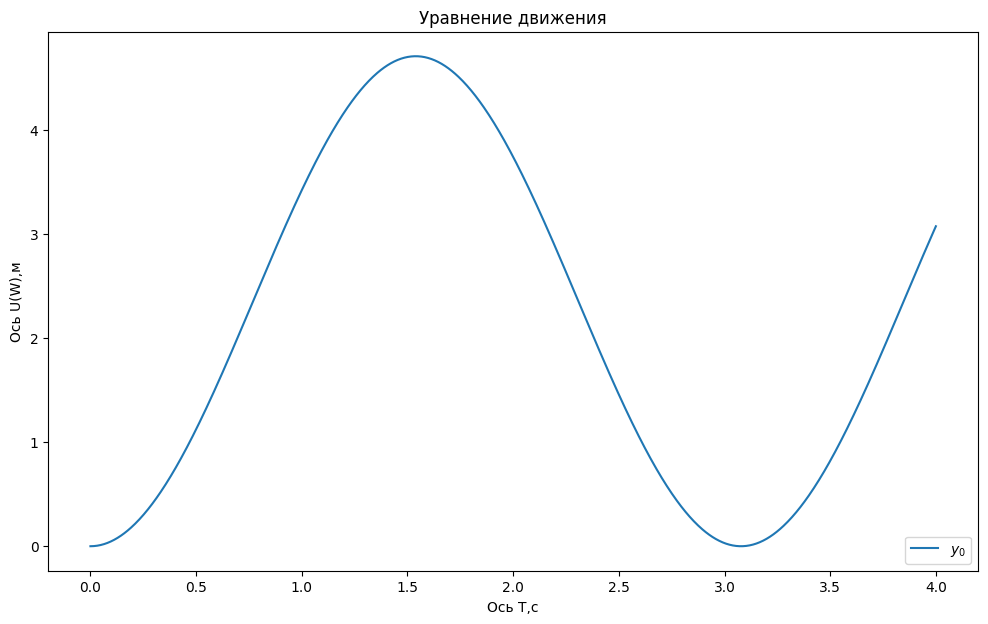

In [ ]:
DLCtask_init()
#print(q/( E * Jx) , N/( E * Jx), ( E * Jx))
# Правые части системы
def rhs(x,w):
  return np.vstack((w[1], (rho * S * 9.8 * z / l1 - mu * w[1] - E * w[0]) / rho / S))
#def rhs(t,u):
#  r = np.zeros(2)
#  r[0] = u[1]
# r[1] = (- mu * u[1] - E * u[0]) / rho / S
#  return r
# Краевые условия
def bc(ua, ub):
  return np.array([ua[0], ua[1]])
totalNodes = 1000
T = 4
t = np.linspace(0, T, totalNodes)
u_a = np.zeros((2, t.shape[0]))
solbc = solve_bvp(rhs,bc,t,u_a, tol = 1e-10, max_nodes=totalNodes)
#solbc = solve_ivp(rhs,(0,T),[0,0],rtol=1e-8,t_eval=t)
print(solbc)
t_measles_plot = np.linspace(0, T, totalNodes)
#u_measles_plot = solbc.sol(t_measles_plot)
uu = solbc.y[0]

print(f'Max deflection  is:{max(abs(uu))}')
set_plot(xlabel="Ось T,c",ylabel='Ось U(W),м',title='Уравнение движения')
plt.plot(t_measles_plot, uu, label='$y_0$')
#plt.plot(x_measles_plot, y_measles_plot[1], label='$y_1$')
#plt.plot(x_measles_plot, y_measles_plot[2], label='$y_2$')
#plt.plot(x_measles_plot, y_measles_plot[3], label='$y_3$')
plt.legend(loc='lower right')
plt.show()

# Усилие по нормальному закону распределения

Max deflection  is:0.023914607938444174


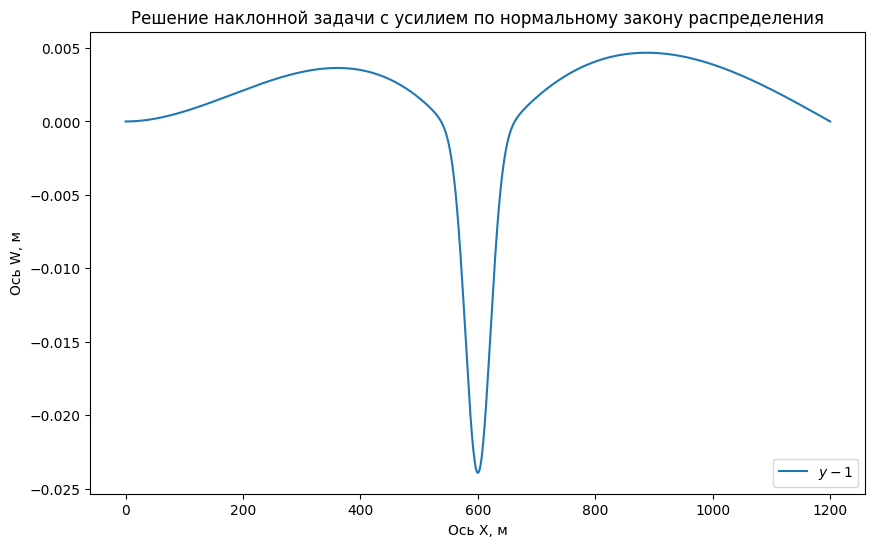

In [ ]:
P0 = 5e5
sigma = 15
z0 = 40 * sigma
E_soil = 4 * 10 ** 7
b = 2 * np.sqrt(5000 * (1 - 0.09) * 0.5 / np.pi / E_soil) # длина дуги
k0 = 20 * 10 ** 6 #коэффициент жесткости основания для глинистых грунтов пластичных
c = k0 * 2 * b
l = 2 * z0
Jx = np.pi * 0.5**4 / 64 * (1 - 0.49**4 / 0.5**4) #1 / 2 * m / l * (0.5**2 + 0.49**2)**2 #момент инерции
E = 2.06 * 10**11 #модуль Юнга
m = 7800 * l * np.pi * (0.5**2 - 0.49**2) #масса трубы
q = m * 9.8 / l #погонный вес трубы
#k04 = c * l ** 4 / (E * Jx) / 4
q_bezrazmer = l ** 3 / (E * Jx) * (P0 / np.sqrt(2 * np.pi) / sigma )
def q_norm(z):
  return  P0 / np.sqrt(2 * np.pi) / sigma* np.exp(- (z - z0) ** 2 / 2 / sigma ** 2)
def k04_norm(z):
  return k0  / (E * Jx) * np.sqrt(q_norm(z) * (1 - 0.09) * 0.5 / np.pi / E_soil)
def funNorm(x,w):
  return np.vstack((w[1],w[2],w[3], -q_norm(x) / (E * Jx) - 4 * k04_norm(x) * w[0] ))
def bc(ya, yb):
  return np.array([ya[0], yb[0], ya[1], yb[2]])
totalNodes = 1000
x_measles_plot = np.linspace(0, l, totalNodes)
set_plot(xlabel="Ось X, м",ylabel='Ось W, м',title='Решение наклонной задачи с усилием по нормальному закону распределения')
x = np.linspace(0, l, totalNodes)
y_a = np.zeros((4, x.shape[0]))
solbci = solve_bvp(funNorm,bc,x,y_a, tol = 1e-10, max_nodes=totalNodes)
y_measles_plot = solbci.sol(x_measles_plot)
plt.plot(x_measles_plot, y_measles_plot[0], label=f'$y-{1}$')
#plt.plot(y_measles_plot[0], y_measles_plot[1], label='$y_0/ y_1$')
plt.legend(loc='lower right')
yy = solbci.y[0]
print(f'Max deflection  is:{max(abs(yy))}')
plt.show()
#print(phi)

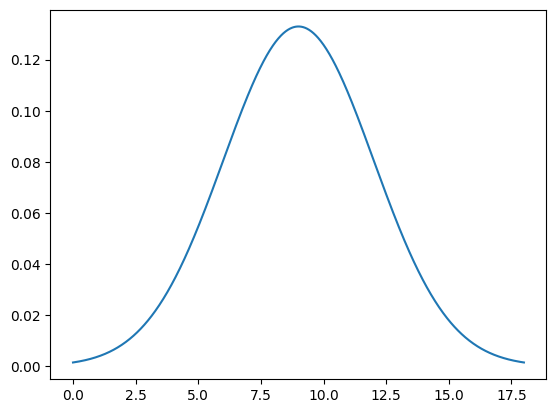

In [ ]:
x0 = l / 2
x = np.linspace(0, l, totalNodes)
Y = 1 / np.sqrt(2 * np.pi) / sigma * np.exp(- (x - x0) ** 2 / 2 / sigma ** 2)
plt.plot(x, Y)

# 125

In [ ]:
def Euler_init():
  global l,m,P,Jx,E,delta,l1,n,alpha
  Jx = np.pi * 0.5**4 / 64 * (1 - 0.49**4 / 0.5**4) #1 / 2 * m / l * (0.5**2 + 0.49**2)**2 #момент инерции
  E = 2.06 * 10**11 #модуль Юнга
  n = 4

  #P = n*np.pi*E*Jx/l**2 #сила сжатия трубы
  P = 1.5e6

  delta = 0.1

  l1 = np.pi/(np.sqrt(P/(E*Jx)))
  l = np.sqrt(n*np.pi**2*E*Jx/P) #длина трубы
  #l1 = l/np.sqrt(n)
  alpha = np.sqrt(P/(E*Jx))
  print(np.pi/alpha)
  print(l1)


17.96729718600746
17.96729718600746
1500000.0
0.09999999999999999


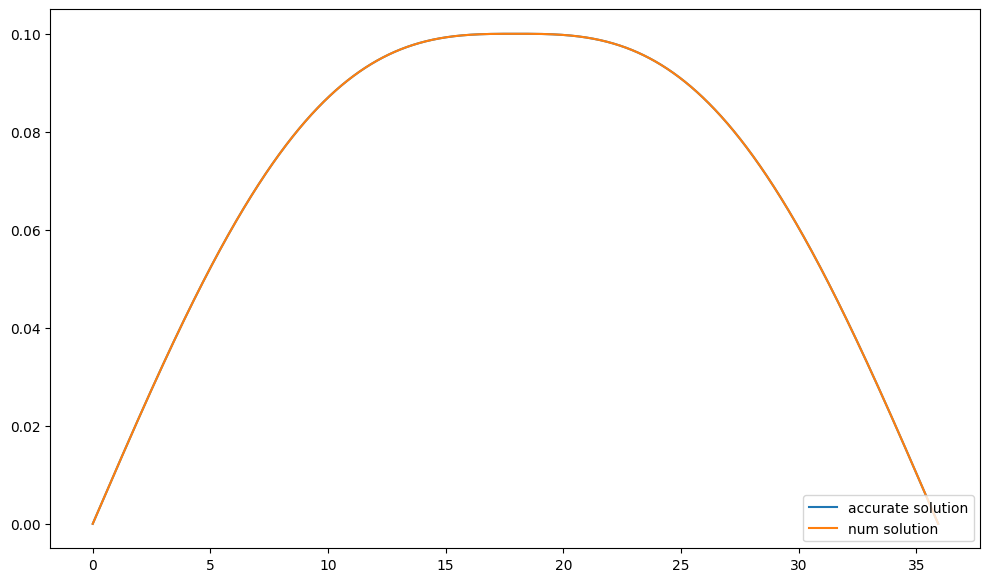

In [ ]:
Euler_init()
print(P)

def Euler_fun1(x,w):
  return np.vstack((w[1],-delta*np.pi/l1**2*np.sin(alpha*x)))
def Euler_fun3(x,w):
  return  np.vstack((w[1],delta*np.pi/l1**2*np.sin(alpha*x)))

# Краевые условия
def bc_E0(ya, yb): # шарниры
  return np.array([ya[0], yb[0]-delta])
def bc_E1(ya, yb): # шарниры
  return np.array([ya[0]-delta, yb[0]])

totalNodes = 1000
x1 = np.linspace(0, l1, totalNodes)
y1 = np.array(delta/np.pi*(np.sin(alpha*x1)+alpha*x1))
x2 = np.linspace(l1, l-l1, totalNodes)
y2 = np.array(y1[-1]*(1-x2+x2))
x3 = np.linspace(l-l1, l, totalNodes)
y3 = np.array(np.sqrt(n)*delta-delta/np.pi*(np.sin(alpha*x3)+alpha*x3))
#y3 = np.array(delta/np.pi*(-np.sin(alpha*x3)+np.pi*np.cos(alpha*x3)+alpha*x3))
x = np.hstack([x1,x2,x3])
y = np.hstack([y1,y2,y3])

tx1 = np.linspace(0, l, totalNodes)
ty1 = np.array(delta/np.pi*(np.sin(alpha*tx1)+alpha*tx1))

tx = np.linspace(0,l,totalNodes)
ty = np.array(delta*np.sin(alpha*tx))
print(y1[-1])
plt.figure(figsize=(12,7))
plt.plot(x,y,label='accurate solution')
plt.legend(loc='lower right')

#plt.plot(tx1,ty1,label='accurate+ solution')
#plt.plot(tx,ty,label='Common accurate solution')
plt.legend(loc='lower right')

w1 = np.zeros((2, x1.shape[0]))
w3 = np.zeros((2, x3.shape[0]))
solbc1 = solve_bvp(Euler_fun1,bc_E0,x1,w1, tol = 1e-10, max_nodes=totalNodes)
solbc3 = solve_bvp(Euler_fun3,bc_E1,x3,w3, tol = 1e-10, max_nodes=totalNodes)
w1 = solbc1.y[0]
w2 = w1[-1]*np.ones(x2.shape[0])
w3 = solbc3.y[0]
w = np.hstack([w1,w2,w3])

plt.plot(x,w,label='num solution')
plt.legend(loc='lower right')
plt.show()